# 01 :: Raw to expression matrix

**Objectives:**

This notebook aims at producing

* Start from filtered raw counts
*`cpm` normalize 
* optionally standardize per slide if necessary

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

sns.set(style="whitegrid")

---

## Raw data from R object to Parquet

* done only once

In [252]:
raw_RData_path = '/media/tmo/data/work/datasets/02_ST/raw/raw_filtered.RData'
raw_parquet    = '/media/tmo/data/work/datasets/02_ST/raw/raw.parquet'
lcpm_parquet   = '/media/tmo/data/work/datasets/02_ST/lcpm/lcpm.parquet'
meta_parquet   = '/media/tmo/data/work/datasets/02_ST/meta/meta.parquet'

In [9]:
# r_load = robjects.r['load']

In [10]:
# r_load(raw_RData_path)

In [11]:
# raw_data_from_r = robjects.r['dat']

* save raw RData to Parquet
* `91.010.996` bytes in compressed Parquet format

In [12]:
# raw_data_from_r.to_parquet(raw_parquet, engine='pyarrow', compression='snappy')

---

# Load raw data from Parquet

In [13]:
%%time
raw_data_from_parquet = pd.read_parquet(raw_parquet)

CPU times: user 7.66 s, sys: 22.8 s, total: 30.5 s
Wall time: 8.97 s


In [14]:
raw_data_from_parquet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10327 entries, N05_C2__20_6 to B05_E2__7_29
Columns: 46454 entries, -343C11.2 to n-TStga1
dtypes: float64(46454)
memory usage: 3.6+ GB


In [15]:
raw_data_from_parquet.head()

,-343C11.2,00R_AC107638.2,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
N05_C2__20_6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N05_C2__17_6,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N05_C2__16_6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N05_C2__19_6,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N05_C2__18_6,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fixed version of log_cpm that retains sparsity

* motivation: account for heteroscedasticy
* avoid using pseudocounts!
* see: https://stackoverflow.com/questions/21752989/numpy-efficiently-avoid-0s-when-taking-logmatrix

In [155]:
def total_sum_scaled(raw_df):
    row_sums = raw_df.sum(axis=1)
    
    tss_df = raw_df.div(row_sums, axis=0)
    
    return tss_df

In [156]:
def log_cpm_special(raw_df):
    
    np.seterr(divide='ignore')
    
    tss_df = total_sum_scaled(raw_df)
    cpm_df = tss_df * 1000000
    lcpm_df = np.log2(cpm_df)
    lcpm_df = lcpm_df.replace(-np.inf, 0)
    
    np.seterr(divide='warn')
    
    return lcpm_df

In [160]:
%%time
tss_df = total_sum_scaled(raw_data_from_parquet)

CPU times: user 25.6 s, sys: 6.21 s, total: 31.8 s
Wall time: 28.1 s


In [224]:
%%time
lcpm_df = log_cpm_special(raw_data_from_parquet)

CPU times: user 37.8 s, sys: 15.7 s, total: 53.4 s
Wall time: 46.9 s


In [225]:
lcpm_df.head()

,-343C11.2,00R_AC107638.2,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
spot_UID,,,,,,,,,,,,,,,,,,,,,
N05_C2__20_6,0.0,0.0,0.0,0.0,0.000000,0.000000,4.570584,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N05_C2__17_6,0.0,0.0,0.0,0.0,6.722953,5.722953,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N05_C2__16_6,0.0,0.0,0.0,0.0,0.000000,5.354258,0.000000,0.0,5.354258,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N05_C2__19_6,0.0,0.0,0.0,0.0,7.603936,0.000000,0.000000,0.0,4.796581,4.796581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N05_C2__18_6,0.0,0.0,0.0,0.0,6.628026,6.628026,0.000000,0.0,0.000000,7.364991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* inspect some expression distributions

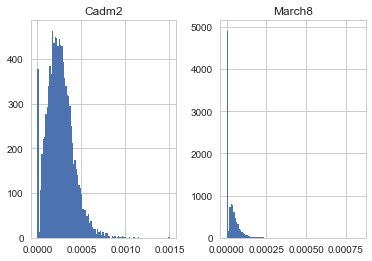

In [228]:
tss_df[['Cadm2', 'March8']].hist(bins=100)
plt.show()

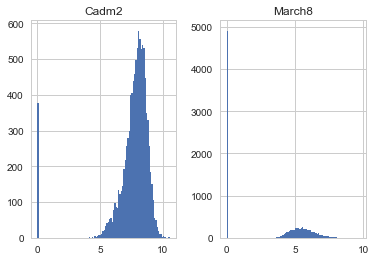

In [229]:
lcpm_df[['Cadm2', 'March8']].hist(bins=100)
plt.show()

In [230]:
lcpm_df.index.name = 'spot_UID'

In [231]:
lcpm_df = lcpm_df.reset_index()

In [251]:
def add_slide_ID(df):
    df['slide_ID'] = df['spot_UID'].apply(lambda x: str(x).split('__')[0])
    
    return df

In [249]:
lcpm_df = add_slide_ID(lcpm_df)

In [250]:
lcpm_df['slide_ID'].dtype

dtype('O')

In [1]:
slides = lcpm_df['slide_ID'].unique()

NameError: name 'lcpm_df' is not defined

In [247]:
slides

[N05_C2, N04_D1, N02_C1, N03_D2, B04_D1, ..., B03_D2, N02_D1, N03_C2, N06_D2, B05_E2]
Length: 20
Categories (20, object): [N05_C2, N04_D1, N02_C1, N03_D2, ..., N02_D1, N03_C2, N06_D2, B05_E2]

In [219]:
def plot_gene_swarm_by_slide(df, gene):
    fig, ax = plt.subplots(figsize=(50, 12))
    
    data = df[['slide_ID', gene]]
    
    g = sns.swarmplot(data=data, x='slide_ID', y=gene, palette="Set1", order=slides)
    g.set_xticklabels(rotation=90, labels=slides)

    plt.show()

* plot logcpm expression per slide `-->` no non-zero artifacts anymore

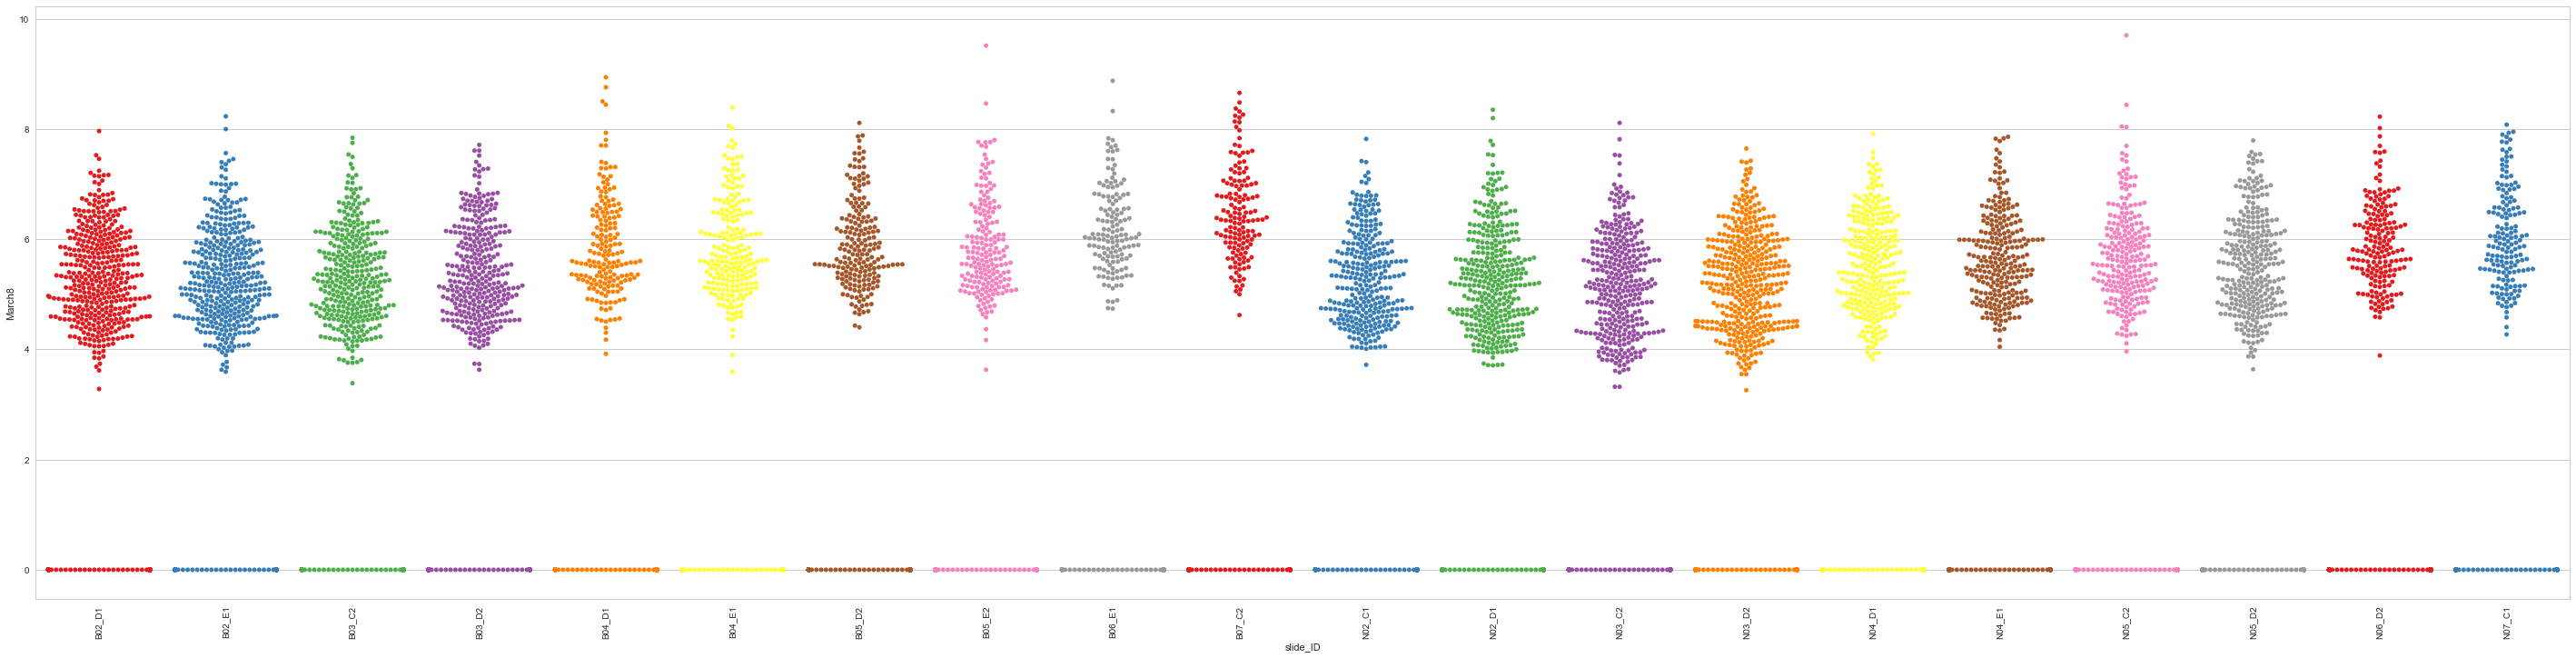

In [221]:
plot_gene_swarm_by_slide(lcpm_df_add, 'March8')

* normalization per slide necessary?
* calculate variance how? non-zero only?

Save lcpm with `'slide_ID'` column to parquet

In [237]:
# lcpm_df.to_parquet(lcpm_parquet, engine='pyarrow', compression='snappy')